# Predicting Price with Size, Location, and Neighborhood

In [1]:
pwd

'C:\\Users\\admin\\Desktop\\Personal_stuff\\PROJECTS\\Proj2_Price model\\notebook'

## Library Importing

In [2]:
from glob import glob
import pandas as pd
import seaborn as sns #for data visualisation
from category_encoders import OneHotEncoder  #encoding categorical values
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact #for the interactive dashboard
from sklearn.impute import SimpleImputer #3imputting missing values
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401--automaed quality control code.
from sklearn.metrics import mean_absolute_error #to evaluate the model
from sklearn.pipeline import make_pipeline  #make the pipoeline
from sklearn.utils.validation import check_is_fitted #for unit testing

## Data Wrangling

In [3]:
#Loading the dataset with a function
def wrangle (filepath):
    #Load the CSV file into file path-local function applied
    df = pd.read_csv(filepath, encoding='ISO-8859-1') #read csv to the dataframe 
    #To display 'Capital Federal' only 
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    #To display 'Apartment' only 
    mask_apt = df["property_type"] == "apartment" 
    #To display price below'400,000'
    mask_price = df["price_aprox_usd"] < 400_000
    #Subset
    df = df[ mask_ba & mask_apt & mask_price]
    
    #Remove outliers by 'surface_area_m2' -----removing the 10th and 90th quantiles
    low = df["surface_covered_in_m2"].quantile(0.1)
    high = df["surface_covered_in_m2"].quantile(0.9)
    
    mask_area = df["surface_covered_in_m2"].between(low, high)
    
    df = df[mask_area]
    
    #split the lat-lon column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    #split place_with_parent_names
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
    
    #drop features with high  null counts
    df.drop(columns=["floor","expenses"], inplace = True) 
    
    #drop low and high cardinality- categorical values
    df.drop(columns= ["operation","property_type","properati_url", "currency"], inplace = True )
    
    #drop leaky columns
    df.drop(columns=['price','price_aprox_local_currency','price_per_m2','price_usd_per_m2'], inplace= True)
    
        #drop columns with multicorlinearlity
    df.drop(columns=["rooms","surface_total_in_m2"], inplace=True)
    
    print('low = ', low, ';high = ', high)
    print('df.shape = ', df.shape)
    
    return df

In [4]:
#Collecting the files with the glob function
files = glob("C:\\Users\\admin\\Desktop\\Personal_stuff\\PROJECTS\\Proj2_Price model\\datasets/buenos-aires-real-estate-*.csv")
files

['C:\\Users\\admin\\Desktop\\Personal_stuff\\PROJECTS\\Proj2_Price model\\datasets\\buenos-aires-real-estate-1.csv',
 'C:\\Users\\admin\\Desktop\\Personal_stuff\\PROJECTS\\Proj2_Price model\\datasets\\buenos-aires-real-estate-2.csv',
 'C:\\Users\\admin\\Desktop\\Personal_stuff\\PROJECTS\\Proj2_Price model\\datasets\\buenos-aires-real-estate-3.csv',
 'C:\\Users\\admin\\Desktop\\Personal_stuff\\PROJECTS\\Proj2_Price model\\datasets\\buenos-aires-real-estate-4.csv',
 'C:\\Users\\admin\\Desktop\\Personal_stuff\\PROJECTS\\Proj2_Price model\\datasets\\buenos-aires-real-estate-5.csv']

In [5]:
#Loading the files with list comprehension to a df 
frames = [wrangle(file) for file in files]

low =  31.0 ;high =  100.0
df.shape =  (1343, 5)
low =  31.0 ;high =  100.0
df.shape =  (1315, 5)
low =  31.0 ;high =  101.70000000000005
df.shape =  (1288, 5)
low =  30.0 ;high =  98.0
df.shape =  (1305, 5)
low =  30.0 ;high =  100.0
df.shape =  (1331, 5)


In [6]:
#type(frames[0]) #indicating its a list 

In [7]:
frames[0].head() #dataframe 1

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
4,129000.0,70.0,-34.584651,-58.454693,Chacarita
9,87000.0,42.0,-34.638979,-58.500115,Villa Luro
29,118000.0,54.0,-34.615847,-58.459957,Caballito
40,57000.0,42.0,-34.625222,-58.382382,Constitución
41,90000.0,50.0,-34.610610,-58.412511,Once


In [8]:
#concatenate the dataframes 
df = pd.concat(frames, ignore_index = True)
df.head()

,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


In [9]:
 df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


In [10]:
#shows percentage of representation of missing values more than 50% drop
#sum of null values in each column 0 rep false and 1 is true
df.isnull().sum()/len(df)

price_aprox_usd          0.000000
surface_covered_in_m2    0.000000
lat                      0.040413
lon                      0.040413
neighborhood             0.000000
dtype: float64

### High & low cardinality- @wrangle fun

In [11]:
#View the datatype object
df.select_dtypes("object").head(5)

,neighborhood
0,Chacarita
1,Villa Luro
2,Caballito
3,Constitución
4,Once


In [12]:
#view the unique values within
df.select_dtypes("object").nunique()

neighborhood    57
dtype: int64

### Leakage- @ wrangle fun

In [13]:
#checking for leakage
sorted(df.columns) #drop the unecessary cols to avoid leakage at the wrangle function

['lat', 'lon', 'neighborhood', 'price_aprox_usd', 'surface_covered_in_m2']

### Multicorlinearlity

In [14]:
#checking for multicolinearity
df.select_dtypes("number").drop(columns="price_aprox_usd").corr()

,surface_covered_in_m2,lat,lon
surface_covered_in_m2,1.000000,0.028538,0.034515
lat,0.028538,1.000000,-0.262439
lon,0.034515,-0.262439,1.000000


<Axes: >

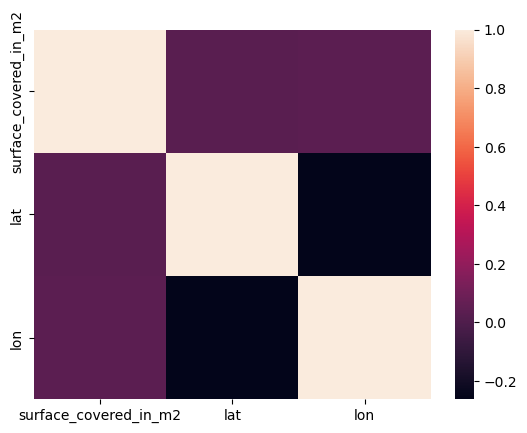

In [15]:
##visualised interpretation
corr= df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


## Model Building & Testing

In [17]:
target= "price_aprox_usd"
features = ["surface_covered_in_m2", "lat", "lon","neighborhood"]

X_train = df[features]
y_train = df[target]

In [18]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)

print("Mean apt price:", round(y_mean, 2))
print("Baseline MAE:", mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.84
Baseline MAE: 44860.10834274133


In [19]:
# Define the model pipeline
model = make_pipeline(
    OneHotEncoder(use_cat_names = True),
    SimpleImputer(),
    Ridge()
)

# Fit the model pipeline
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [20]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train,y_pred_training))


Training MAE: 24207.10719033039


## Generalisation

In [22]:
X_test = pd.read_csv("C:\\Users\\admin\\Desktop\\Personal_stuff\\PROJECTS\\Proj2_Price model\\datasets/buenos-aires-test-features.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

## Results Communication

In [24]:
def make_prediction(area, lat, lon, neighborhood):
    data = {"surface_covered_in_m2":area,
                        "lat":lat,
                        "lon":lon,
                        "neighborhood":neighborhood
    }
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [25]:
#Illustration
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $250775.11'

## Visualisation - Interactive Dashboard

In [26]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…

## Conclusion

The interactive dashboard below enables one to make price predictions based on the 4 inputs(features) provided being the area-how big it is, the location in regards to the latitude and longitude and the neighbourhood.
For instance: An apartment in an affluent neighborhood whose surface area is very large and is located on the coastline will have a higher price in comparison to the vice versa.
                                                                                         